# 演習その１ Grad-TTSを動かしてみる

In [1]:
# Build Monotonic Alignment Search code (Cython)
!cd model/monotonic_align; python setup.py build_ext --inplace

running build_ext


In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

# 1.モデルのロード
Grad-TTSによる音声合成のためには以下３つのモジュールが必要です
## CMUDict
文字列を音素列に変換するための辞書<br>
入力：文字列<br>
出力：文字列(音素列)
<br>
## Grad-TTS
拡散モデルに基づいて音声合成(TextToSpeech;TTS)を行うモデル<br>
入力：文字列(音素列)<br>
出力：メルスペクトログラム
<br>
## HiFiGAN
メルスペクトログラムから音声波形を生成するモデル<br>
入力：メルスペクトログラム<br>
出力：音声波
<br>

## 1.1 CMUDictのロード

In [4]:
cmu = cmudict.CMUDict('./resources/cmu_dictionary')

print("アルファベット:", "a", "音素：", cmu.lookup("a"))
print("アルファベット:", "b", "音素：", cmu.lookup("b"))
print("アルファベット:", "c", "音素：", cmu.lookup("c"))

アルファベット: a 音素： ['EY1']
アルファベット: b 音素： ['B IY1']
アルファベット: c 音素： ['S IY1']


## 1.2 GradTTSのロード

In [5]:
# N_SPKS = 247  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)
N_SPKS = 1
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
# generator.load_state_dict(torch.load('./checkpts/grad-tts-libri-tts.pt', map_location=lambda loc, storage: loc))
generator.load_state_dict(torch.load('./checkpts/grad-tts.pt', map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

Number of parameters: 14835032


## 1.3 HiFiGAN

In [6]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


# 2.音声生成

In [7]:
# text = "Here are the match lineups for the Colombia Haiti match."
# text = "I'm looking forward to seeing you again."
text = "Hello. I am an artificial intelligence for voice generation."

In [8]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 113]), tensor([113], device='cuda:0'))

Grad-TTS RTF: 0.6438217955318768


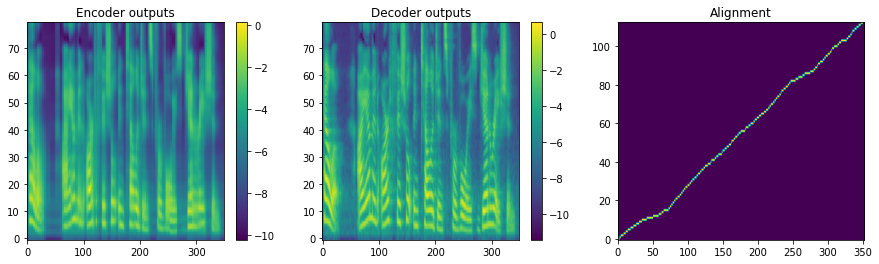

In [9]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

In [10]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))